In [1]:
import findspark
findspark.init()
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, variance

# 1. KHỞI TẠO SPARK SESSION

spark = SparkSession.builder \
    .appName("ThongKeTongHop") \
    .getOrCreate()

spark.sparkContext.setLogLevel("WARN")
print("✅ Spark Session đã được khởi tạo.")

# 2. ĐỌC VÀ LÀM SẠCH DỮ LIỆU
df = spark.read.csv(
    "Exam_Score_Prediction.csv",
    header=True,
    inferSchema=True
)

✅ Spark Session đã được khởi tạo.


In [2]:
#Tóm tắt dataset
df.printSchema()
print(f"✔️ Đã đọc xong file CSV. Tổng số dòng ban đầu: {df.count()}")

root
 |-- Age: integer (nullable = true)
 |-- Grade: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Race: string (nullable = true)
 |-- SES_Quartile: integer (nullable = true)
 |-- ParentalEducation: string (nullable = true)
 |-- SchoolType: string (nullable = true)
 |-- Locale: string (nullable = true)
 |-- TestScore_Math: double (nullable = true)
 |-- TestScore_Reading: double (nullable = true)
 |-- TestScore_Science: double (nullable = true)
 |-- GPA: double (nullable = true)
 |-- AttendanceRate: double (nullable = true)
 |-- StudyHours: double (nullable = true)
 |-- InternetAccess: integer (nullable = true)
 |-- Extracurricular: integer (nullable = true)
 |-- PartTimeJob: integer (nullable = true)
 |-- ParentSupport: integer (nullable = true)
 |-- Romantic: integer (nullable = true)
 |-- FreeTime: integer (nullable = true)
 |-- GoOut: integer (nullable = true)

✔️ Đã đọc xong file CSV. Tổng số dòng ban đầu: 999997


In [3]:
selected_df = df.select(
    "TestScore_Math", 
    "TestScore_Reading", 
    "TestScore_Science", 
    "GPA", 
    "AttendanceRate", 
    "StudyHours"
)

# Hiển thị thử dữ liệu đã lọc
selected_df.show(5)

+-----------------+-----------------+-----------------+------------------+------------------+------------------+
|   TestScore_Math|TestScore_Reading|TestScore_Science|               GPA|    AttendanceRate|        StudyHours|
+-----------------+-----------------+-----------------+------------------+------------------+------------------+
| 72.3460528447449|62.21713351639229|73.00807889463236|2.5217451524536125|0.8688360432403565|0.3101719917535119|
|77.88915720755975| 72.7480296219012|76.30371730997359| 3.275626380290499|0.9095952818526688|1.1755861596452644|
| 72.9665874046004|65.58547210049495| 68.0994108132026|2.9741374719165763| 0.870951578475618|1.1125564579521758|
|96.67404896330876|88.03585249635026|            100.0| 3.676589575877245|               1.0|1.0676785748713569|
|81.98927004235313|77.48537152781451|72.71506603466747| 2.255013810453565|0.8979571774575529|0.8419359193908119|
+-----------------+-----------------+-----------------+------------------+------------------+---

In [4]:
from pyspark.sql.functions import col, count, when, isnan
#Kiểm tra giá trị null
selected_df.select([count(when(col(c).isNull() | isnan(c), c)).alias(c) for c in selected_df.columns]).show()

+--------------+-----------------+-----------------+---+--------------+----------+
|TestScore_Math|TestScore_Reading|TestScore_Science|GPA|AttendanceRate|StudyHours|
+--------------+-----------------+-----------------+---+--------------+----------+
|             0|                0|                0|  0|             0|         0|
+--------------+-----------------+-----------------+---+--------------+----------+



In [5]:
duplicate_count = selected_df.count() - selected_df.dropDuplicates().count()
print(f"Số dòng trùng lặp: {duplicate_count}")
selected_df = selected_df.dropDuplicates()

Số dòng trùng lặp: 0


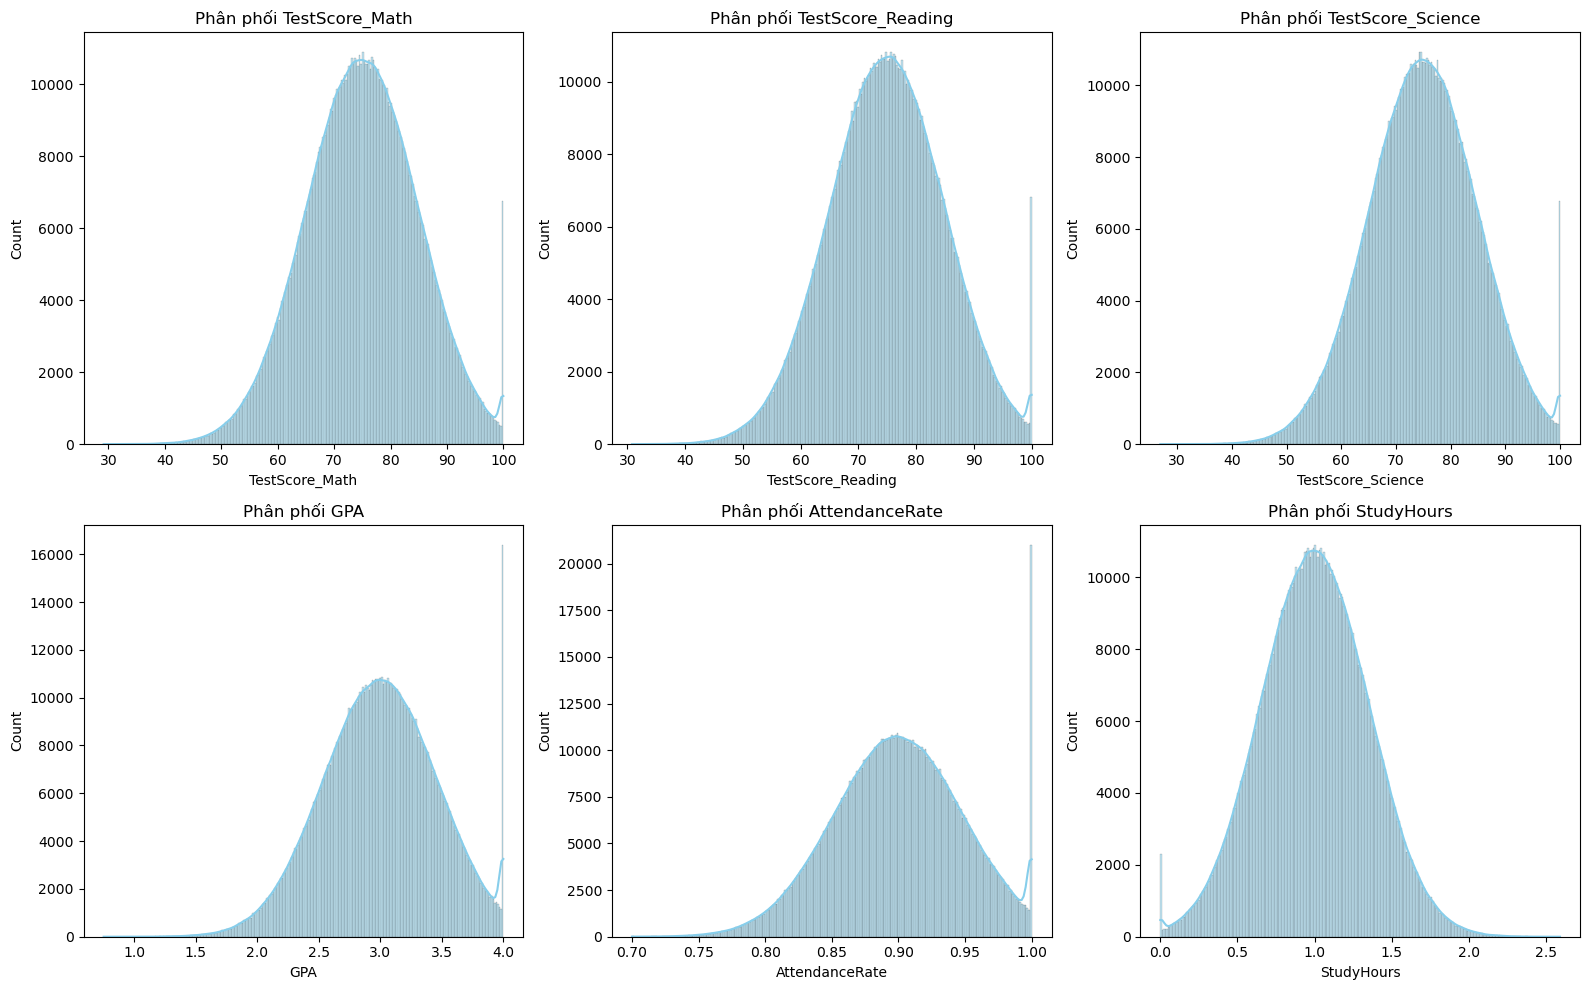

In [ ]:
#HISTOGRAM
# 1. Chuyển selected_df sang Pandas để vẽ đồ họa
pdf = selected_df.toPandas()
cols = ["TestScore_Math", "TestScore_Reading", "TestScore_Science", "GPA", "AttendanceRate", "StudyHours"]

# 2. Thiết lập khung hình (2 hàng, 3 cột)
plt.figure(figsize=(16, 10))

for i, col_name in enumerate(cols, 1):
    plt.subplot(2, 3, i)
    # Vẽ histogram kèm đường cong mật độ (kde)
    sns.histplot(pdf[col_name], kde=True, color="skyblue")
    plt.title(f'Phân phối {col_name}')

plt.tight_layout()
plt.show()

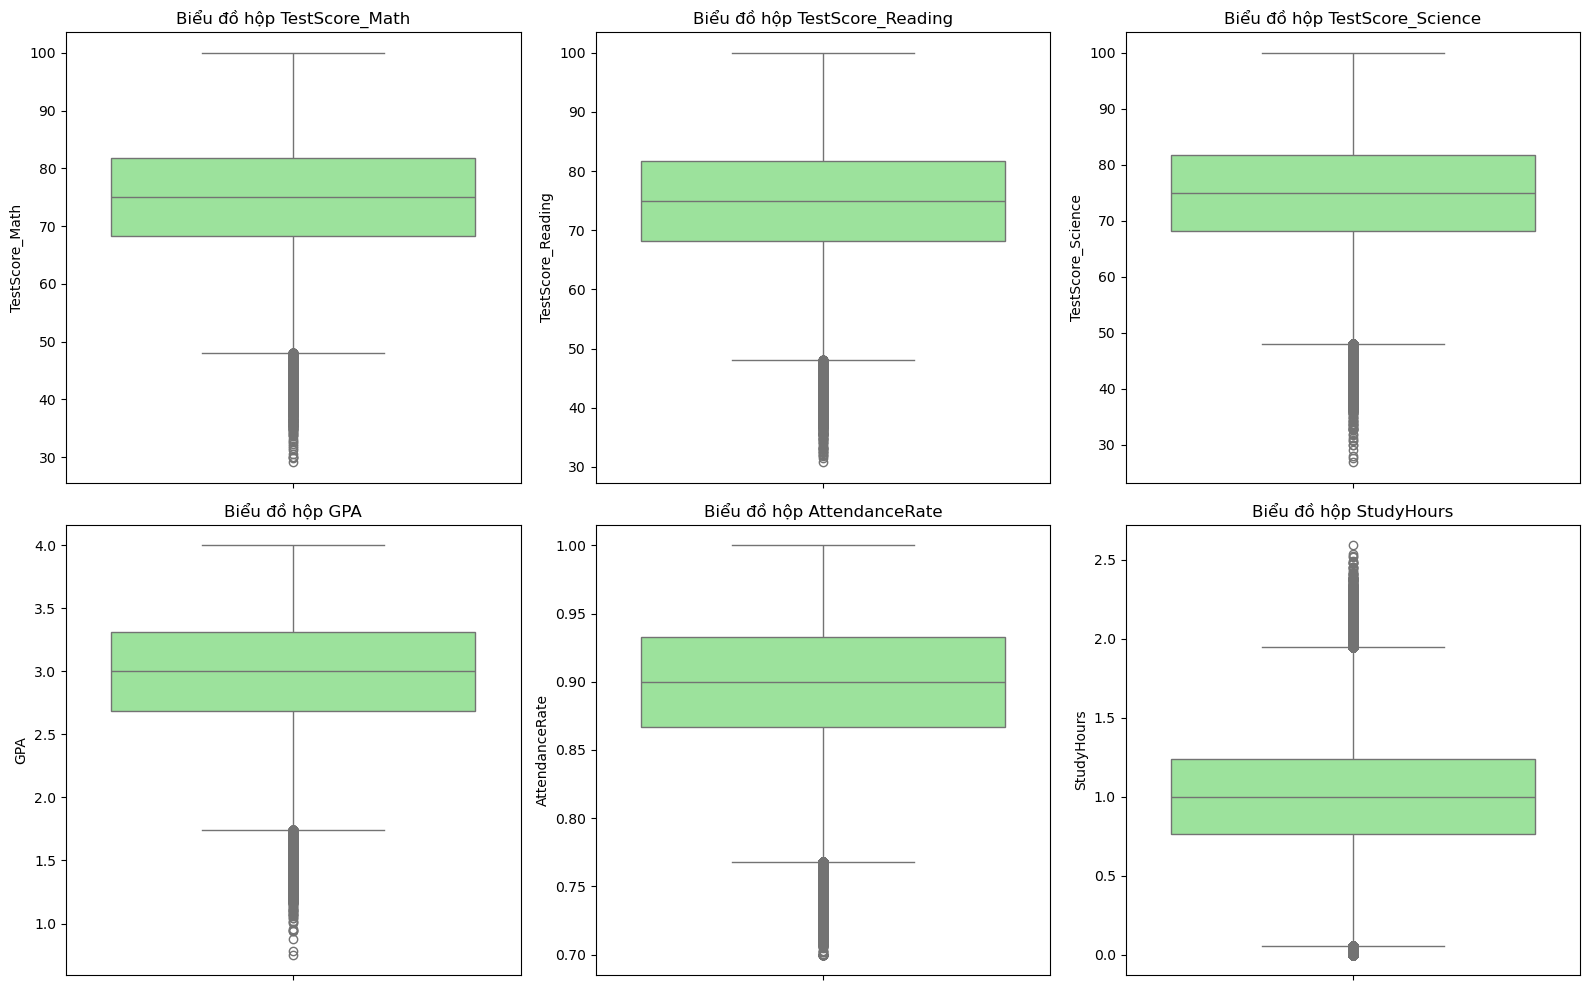

In [7]:
#BOXPLOT
# Thiết lập khung hình mới cho Boxplot
plt.figure(figsize=(16, 10))

for i, col_name in enumerate(cols, 1):
    plt.subplot(2, 3, i)
    # Vẽ biểu đồ hộp
    sns.boxplot(y=pdf[col_name], color="lightgreen")
    plt.title(f'Biểu đồ hộp {col_name}')

plt.tight_layout()
plt.show()

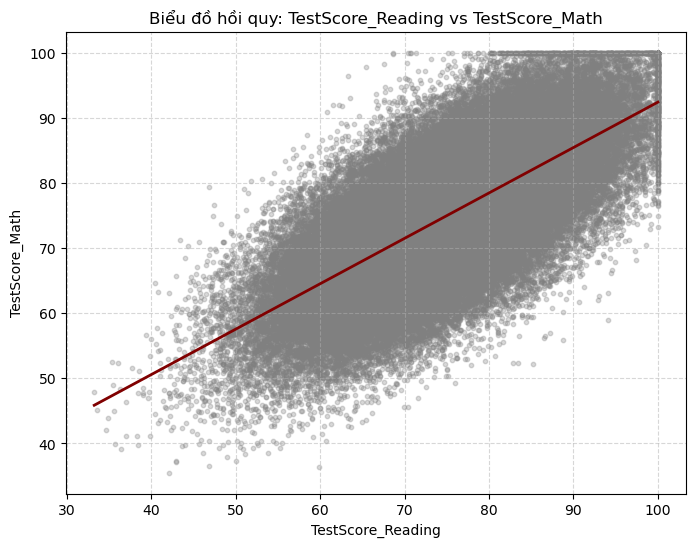

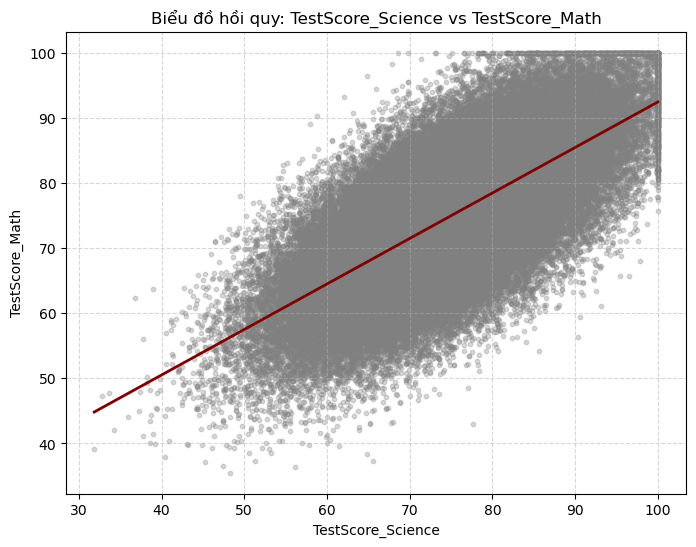

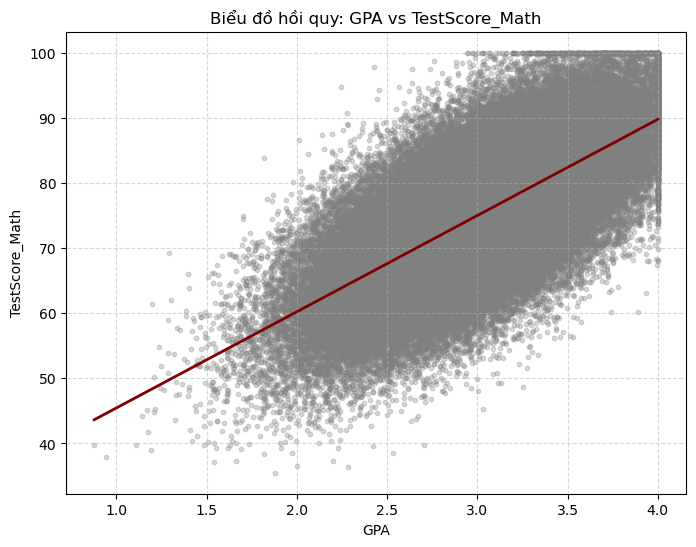

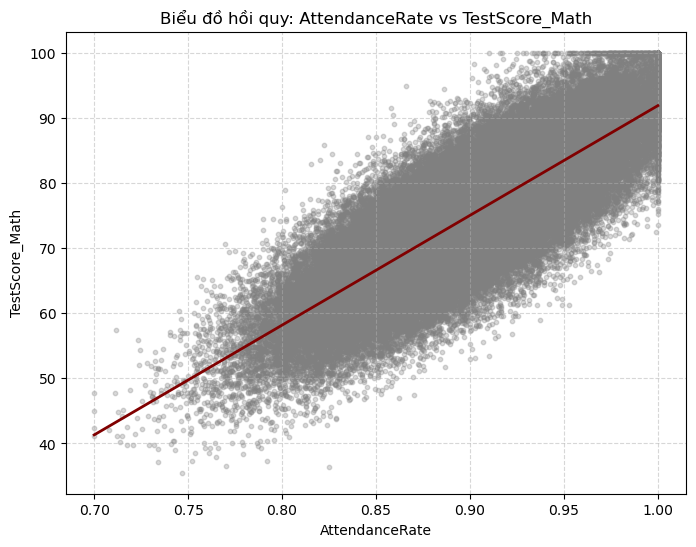

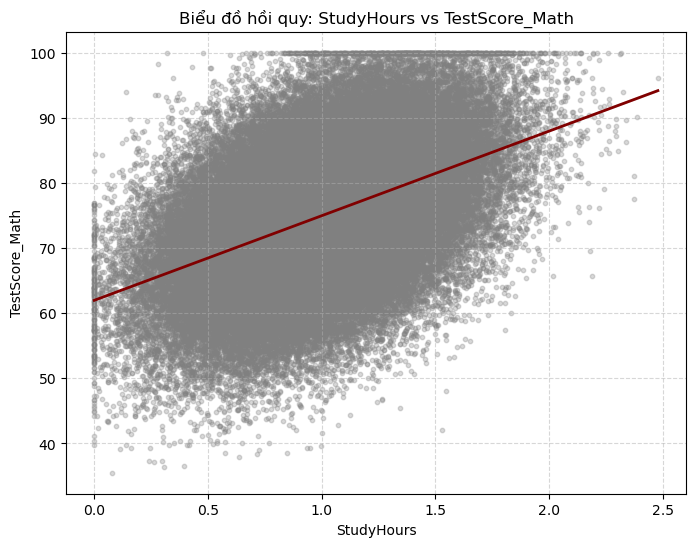

In [8]:

# 1. Lấy mẫu dữ liệu (Sampling)
# Fraction=0.1 nghĩa là lấy 10% dữ liệu. Nếu dữ liệu cực lớn, bạn có thể giảm xuống 0.01 (1%)
pdf_sampled = selected_df.sample(withReplacement=False, fraction=0.1, seed=42).toPandas()

# 2. Danh sách 5 thuộc tính độc lập
features = ["TestScore_Reading", "TestScore_Science", "GPA", "AttendanceRate", "StudyHours"]

# 3. Vẽ từng biểu đồ riêng biệt (Không dùng subplot)
for col_name in features:
    # Tạo một khung hình mới hoàn toàn cho mỗi thuộc tính
    plt.figure(figsize=(8, 6))
    
    # Vẽ biểu đồ hồi quy theo phong cách ảnh mẫu (image_bfc823.png)
    sns.regplot(
        data=pdf_sampled, 
        x=col_name, 
        y="TestScore_Math", 
        scatter_kws={'alpha':0.3, 'color':'gray', 's':10}, # Điểm dữ liệu mờ để thấy mật độ
        line_kws={'color':'maroon', 'linewidth':2}        # Đường hồi quy màu nâu đỏ
    )
    
    # Tùy chỉnh tiêu đề và nhãn
    plt.title(f'Biểu đồ hồi quy: {col_name} vs TestScore_Math', fontsize=12)
    plt.xlabel(col_name)
    plt.ylabel('TestScore_Math')
    plt.grid(True, linestyle='--', alpha=0.5)
    
    # Hiển thị biểu đồ ngay lập tức
    plt.show()

In [10]:
from pyspark.sql import functions as F
final_data = selected_df
# 1. Tính Mean và StdDev cho cột mục tiêu
stats = final_data.select(
    F.mean("TestScore_Math").alias("avg"), 
    F.stddev("TestScore_Math").alias("std")
).collect()

avg_val = stats[0]['avg']
std_val = stats[0]['std']

# 2. Lọc bỏ những dòng có điểm Math quá thấp hoặc quá cao (ngoài khoảng 3 độ lệch chuẩn)
# Công thức: |x - mean| <= 3 * std
final_data_clean = final_data.filter(
    F.abs(F.col("TestScore_Math") - avg_val) <= (3 * std_val)
)

print(f"Số dòng sau khi lọc ngoại lai: {final_data_clean.count()}")

Số dòng sau khi lọc ngoại lai: 998589


In [11]:
final_data.head(5)

[Row(TestScore_Math=91.53355495322025, TestScore_Reading=87.79463802638351, TestScore_Science=96.80450692996985, GPA=3.7197557611757217, AttendanceRate=0.9667684762904658, StudyHours=1.596989484885987),
 Row(TestScore_Math=78.16777983966107, TestScore_Reading=77.86470140176164, TestScore_Science=80.80195397637107, GPA=2.621570726246386, AttendanceRate=0.9071573590539715, StudyHours=0.6829836063679351),
 Row(TestScore_Math=81.21000641621734, TestScore_Reading=65.78727779447941, TestScore_Science=77.41139954352923, GPA=3.025391269598156, AttendanceRate=0.874389959037967, StudyHours=0.9826775124935684),
 Row(TestScore_Math=56.273635623608605, TestScore_Reading=67.72709007452632, TestScore_Science=59.988363636980814, GPA=2.508197754848436, AttendanceRate=0.8290964839955597, StudyHours=0.269593207821099),
 Row(TestScore_Math=56.31873500377441, TestScore_Reading=56.756703952711305, TestScore_Science=63.91625000935029, GPA=2.5421156064677515, AttendanceRate=0.8643512294328364, StudyHours=0.75

In [ ]:
from pyspark.ml.feature import VectorAssembler, MinMaxScaler

# 1. Xác định danh sách các cột tính năng (Features)
# Loại trừ cột mục tiêu TestScore_Math ra khỏi danh sách này
feature_cols = ["TestScore_Reading", "TestScore_Science", "GPA", "AttendanceRate", "StudyHours"]

# 2. KHỞI TẠO VECTOR ASSEMBLER (Bước tạo ra biến 'output')
# Bước này gom 5 cột trên thành 1 cột duy nhất tên là 'features'
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

# 3. CHUYỂN ĐỔI DỮ LIỆU
output = assembler.transform(final_data)

# 4. KHỞI TẠO MIN-MAX SCALER
# Đầu vào là cột 'features' vừa tạo, đầu ra là cột 'scaledFeatures' đã được chuẩn hóa về [0, 1]
scaler = MinMaxScaler(inputCol="features", outputCol="scaledFeatures")

# 5. TÍNH TOÁN VÀ THỰC HIỆN CHUẨN HÓA
scalerModel = scaler.fit(output)
scaledData = scalerModel.transform(output)

# 6. TẠO TẬP DỮ LIỆU CUỐI CÙNG CHO MÔ HÌNH
# Chỉ lấy cột đã chuẩn hóa và cột mục tiêu
final_model_data = scaledData.select("scaledFeatures", "TestScore_Math")

# Kiểm tra thử kết quả
final_model_data.show(5, truncate=False)

+-------------------------------------------------------------------------------------------------+------------------+
|scaledFeatures                                                                                   |TestScore_Math    |
+-------------------------------------------------------------------------------------------------+------------------+
|[0.8236302901408209,0.9562765135499521,0.9136948598920178,0.8892282543015527,0.6164244612682421] |91.53355495322025 |
|[0.6801408921868438,0.7373158111171827,0.5754933906960887,0.6905245301799052,0.2636259071176366] |78.16777983966107 |
|[0.5056199150894629,0.690923327217629,0.6998555853255712,0.5812998634598902,0.37930522522038396] |81.21000641621734 |
|[0.5336505568477895,0.4525263544551508,0.5405785955801984,0.4303216133185324,0.10406070263171614]|56.273635623608605|
|[0.3751264736186235,0.5062710764169491,0.5510240732408552,0.5478374314427881,0.29149146889016814]|56.31873500377441 |
+-----------------------------------------------